# Toy Examples on NFs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils import data
import torch.nn as nn
import torch.distributions as D

from transforms import AffineElementwiseTransform, PositiveLinearTransform
from flows import Flow

%matplotlib inline

## 1D Normal Base Distribution & Affine Transformation

### Target distribution & Synthetic data

In [26]:
# Define 1D target distributions
# We do not usually know them... but we have access to samples!
# We will try to approximate them using the samples!

# Gaussian distribution
mean = 5.
std = 0.2
normal_dist = D.Normal(mean, std) 

# Gaussian Mixture Model with 2 equally weighted normal distributions
mix = D.Categorical(torch.ones(2,))
comp = D.Normal(torch.randn(2,)+torch.ones(2,)*10, torch.rand(2,))
gmm_dist = D.MixtureSameFamily(mix, comp)

# Exponential distribution
rate = 1
exp_dist = D.Exponential(rate)

target_dists = {'gaussian': normal_dist, 'gmm': gmm_dist, 'exp': exp_dist}

In [27]:
# Generate training data samples
target_dist = target_dists['gaussian'] # We do not usually know this...
x_samples = target_dist.sample((50,))  # ...but all we have are these samples.

### Flow and training

In [28]:
# Define base distribution 
base_dist = D.Normal(torch.tensor(0.0), torch.tensor(1.0))

# Define transformation
transform = AffineElementwiseTransform()

# Construct Flow
flow = Flow(base_dist, transform)

# Fit flow to the x_samples: learn the parameters of the transformation 
flow.train(x_samples, num_epochs=1000)


### Evaluate learned distribution

In [29]:
# Draw samples from the learned distribution 
x_samples_new = flow.sample(100)

# If the target distribution is Normal, we can check if mean and std were correctly learned 
print(torch.mean(x_samples_new))
print(torch.std(x_samples_new))

tensor(4.9375, grad_fn=<MeanBackward0>)
tensor(0.2092, grad_fn=<StdBackward0>)


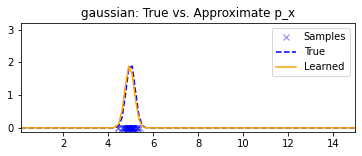

In [30]:
# Evaluate the learnt transformation by plotting the learnt p_x against the samples drawn from the 'true' distribution

def plot_pdfs(target_dist, x_samples, flow, title=None, x_i=0.1, x_f=15, n=100):
    eval_x = torch.linspace(x_i, x_f, n)

    p_x_learned = flow.learned_pdf(eval_x)

    p_x_true = torch.exp(target_dist.log_prob(eval_x))

    fig = plt.figure(figsize=(6, 2))
    plt.plot(x_samples, np.zeros_like(x_samples), 'bx', alpha=0.5, markerfacecolor='none', markersize=6)
    plt.plot(eval_x.numpy(), p_x_true.detach().numpy(),'--', color='blue')
    plt.plot(eval_x.numpy(), p_x_learned.detach().numpy(), color='orange')
    plt.legend(["Samples", "True", "Learned"], loc="upper right")
    _ = plt.xlim([0.1, 15]); _ = plt.ylim([-0.12, 3.2])
    plt.title(title)
    plt.show()

plot_pdfs(target_dist, x_samples, flow, title = 'gaussian: True vs. Approximate p_x')


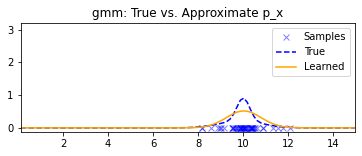

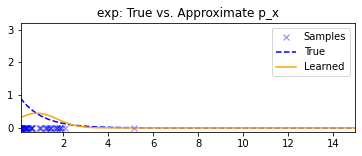

In [31]:
# Plot for gmm eand exp distributions
for dist in ['gmm','exp']:
    target_dist = target_dists[dist] 
    x_samples = target_dist.sample((50,))  

    base_dist = D.Normal(torch.tensor(0.0), torch.tensor(1.0))
    transform = AffineElementwiseTransform()
    flow = Flow(base_dist, transform)
    flow.train(x_samples, num_epochs=500)

    plot_pdfs(target_dist, x_samples, flow, title = dist+': True vs. Approximate p_x')

TODO:
- try other transformation (e.g. splines)

AFTER:
- look at multivariate-gaussians (affine = elementwise)
- linear flow for $D > 1$
- stacking different transforms 
- MAF, NSF
- create flow class 

## 2D Multivariate Gaussian + Affine Transformation

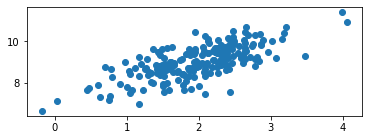

In [21]:
from torch.distributions.multivariate_normal import MultivariateNormal

n=200 # Number of datapoints
d=2 # Dimension of the multivariate normal distribution

means = torch.FloatTensor([2, 9])
cov_matrix = torch.eye(d)*0.3 + torch.rand((d,d))

multi_normal_dist = MultivariateNormal(means, cov_matrix)  # We do not usually know this...
x_samples = multi_normal_dist.sample((n,))  # ...but all we have are these samples.


fig = plt.figure(figsize=(6, 2))
plt.scatter(x_samples[:, 0], x_samples[:, 1])
plt.show()

In [22]:
base_dist = D.MultivariateNormal(torch.zeros(d), torch.eye(d))
transform = AffineElementwiseTransform(z_dim=d)
flow = Flow(base_dist, transform)
flow.train(x_samples, num_epochs=500, lr=0.02)

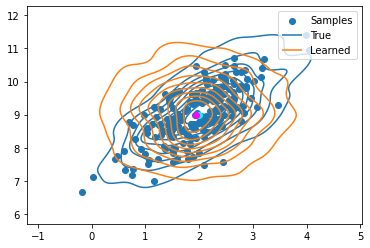

In [23]:
# Evaluate learned distribution
x_true = multi_normal_dist.sample((500,))  # Sample from groundtruth
x_learned = flow.sample(500).detach().numpy()  # Sample from learned
means_learned = np.mean(x_learned, axis=0)  # Learned mean

plt.scatter(x=x_samples[:,0], y=x_samples[:,1]) # Plot training samples
sns.kdeplot(x=x_true[:,0], y=x_true[:,1])  # Plot true distribution
sns.kdeplot(x=x_learned[:,0], y=x_learned[:,1])  # Plot learned distribution
plt.legend(["Samples", "True", "Learned"], loc="upper right")
plt.scatter(x=means[0], y=means[1], color='cyan')
plt.scatter(x=means_learned[0], y=means_learned[1], color='magenta')
plt.show()

The mean is rather well approximated, but not the std. This is because elementwise transformation do not take into account the covariance between coordinates. 

Let's look at linear transformations $x=Au$ with A a $d \times d$ matrix. 

## 2D Linear Flow

In [24]:
d=2
base_dist = D.MultivariateNormal(torch.zeros(d), torch.eye(d))
transform = PositiveLinearTransform(z_dim=d)
flow = Flow(base_dist, transform)
flow.train(x_samples, num_epochs=500, lr=0.005)

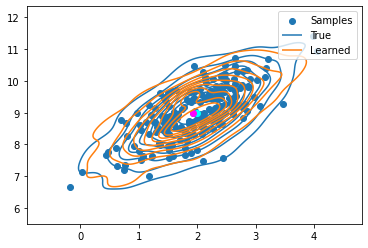

In [25]:
# Evaluate learned distribution
x_true = multi_normal_dist.sample((500,))  # Sample from groundtruth
x_learned = flow.sample(500).detach().numpy()  # Sample from learned
means_learned = np.mean(x_learned, axis=0)  # Learned mean

plt.scatter(x=x_samples[:,0], y=x_samples[:,1]) # Plot training samples
sns.kdeplot(x=x_true[:,0], y=x_true[:,1])  # Plot true distribution
sns.kdeplot(x=x_learned[:,0], y=x_learned[:,1])  # Plot learned distribution
plt.legend(["Samples", "True", "Learned"], loc="upper right")
plt.scatter(x=means[0], y=means[1], color='cyan')
plt.scatter(x=means_learned[0], y=means_learned[1], color='magenta')
plt.show()